# Link Analysis



In the lesson of today we will:

1. play with nodes centralities
2. implement from scratch Adamic-Adar and Jaccard link predictors
3. split train-test for predicting missing links
4. introduce ALS
5. test and compare results generated by ALS


In [1]:
!pip install python-igraph
!pip install implicit

In [2]:
import igraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from collections import Counter
import implicit

In [3]:
# Mount Drive
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)
data_path = '/content/drive/Shareddrives/IRWA-Project/Final version/Output_v5_ment_anonim.csv'


Mounted at /content/drive


We create a random graph following the preferential attachment rule (Barabasi-Albert)

In [4]:
ment =pd.read_csv(data_path, quotechar='"',low_memory=False)
keep = 150000
q=ment[:keep]
q=q[['user_mentioner','user_mentionated']].values.tolist()
t=set()
[t.add(y)  for x in q for y in x]
q=[tuple(x) for x in q]
q=list(set(q))
graph = igraph.Graph()
graph.add_vertices(list(t))

graph.add_edges(q)


In [5]:
print(len(graph.vs))
print(len(graph.get_edgelist()))

68003
115384


In [6]:
import random
# First we are going to reduce the graph eliminating all the nodes not very conected with a small degre beacause we supose that aren't important people. And we need to reduce the dimension of the graph
repeat = 20
for i in range(repeat):
  to_delete=[]
  for n1 in graph.vs:
    if (graph.degree(n1)<4):    #To reduce the dispersion we are going to delete those with low degree that are going to make that are hard to guess
      to_delete.append(n1)
  graph.delete_vertices(to_delete)
to_delete=[]



In [7]:
print(len(graph.vs))
print(len(graph.get_edgelist()))
from collections import Counter 

#Counter(graph.degree())

6906
42800


We then plot the graph through a log-log plot, where on x-axis we find a degree value d and on the y the number of nodes having such degree. Both values are in log-10 scale

In [8]:
def plot_loglog(degree_lst):
    """
    starting from a list of degrees, it plots the log-log
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # x is the degree, y the count
    degrees_distribution = Counter(degree_lst)
    
    # distinct degree 
    degrees_ = []
    # number of nodes having same degree
    count_ = []
    for d in degrees_distribution:
        
        # append both info, key and values
        degrees_.append(d)
        count_.append(degrees_distribution[d])
        
    # logarithmic scale of both axis
    x = np.log10(np.array(degrees_)+1)

    y = np.log10(np.array(count_)+1)
    
    # plot
    ax.scatter(x=x,y=y, alpha=0.5)
    
    plt.xlabel("Degree")
    plt.ylabel("Freq")
    plt.grid()
    plt.show()

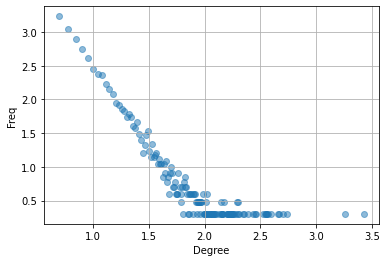

In [9]:
plot_loglog(graph.degree())

Here we play with the nodes' centralities computed through igraph

# 3. Generate train-test for predicting missing links
(**strongly relevant for the project**)


We will se now how to extract a set of edges from the graph and predict the score of accuracy for them.

As a classical practice applied by most of the OSN platforms, we extract as potential candidates to be recommended all the nodes at distance 2 (e.g friends of friends). 

This process will help us to check then the performance of the model, since we will look at the extracting edges considered as test-set (and then as missing links too).

In [10]:
graph.vs[0]

igraph.Vertex(<igraph.Graph object at 0x7f883827f8b8>, 0, {'name': '00c2b9005435b99920cfe997fae8f502'})

In [11]:
def find_nodes_at_distance_2(graph):
    """
    starting from a graph this function returns all the nodes at distance 2
    """
    
    q=len(graph.es)
    all_potential_recommendations = set()
    count=0
    t=len(graph.vs)
    for n1 in graph.vs:
        count +=1
        if count%1000==0:print(count/t)
        # all the nodes at distance 1
        nodes_at_most_distant_1 = set(graph.neighborhood(vertices=n1, order=1))

        # all the nodes at distance 1 and distance 2

        nodes_at_most_distant_2 = set(graph.neighborhood(vertices=n1, order=2))
        
        # only the nodes at distance 2
        only_nodes_at_distance_2 = nodes_at_most_distant_2 - nodes_at_most_distant_1
        
        
        # check if empty set
        if(len(only_nodes_at_distance_2) > 0):
            for n2 in only_nodes_at_distance_2:
                
                # since n1 is an igraph vertex object, we need to extract the id
                n1_index = n1.index
                #if(len(all_potential_recommendations)<int(q*0.2)):
                all_potential_recommendations.add((n1_index, n2))
            
    return all_potential_recommendations

To create the test we need to sample a fraction $p$ of the existing edges in the graph. 

To do that, we look at the edgelist and sample $p \times N$ nodes.

We sample the indexes of the edges through the function np.random.choice

In [12]:
all_potential_recommendations = find_nodes_at_distance_2(graph)

0.1448016217781639
0.2896032435563278
0.43440486533449174
0.5792064871126557
0.7240081088908196
0.8688097306689835


In [13]:

len(all_potential_recommendations)

11023764

In [14]:
# fraction of edges to select as test-set
p = 0.2

# graphsize
N = len(graph.es)

# idxs of all the edges
all_idxs = range(N)

# sample idxs of edges through the function "choice"
test_idxs = np.random.choice(N,int(N*p))
all_potential_recommendations_list = np.random.choice(list(range(len(all_potential_recommendations))),int(N*p))



In [15]:
new = []
lista =list(all_potential_recommendations)
for rec in all_potential_recommendations_list:
  new.append(lista[rec])
all_potential_recommendations = set(new)

We then select the edges scrolling the edgelist graph.es

In [16]:
ground_truth = set()
trainset = set()
for idx, one_edge in enumerate(graph.es):
    
    # take n1 and n2 idx from one_edge, that is an igraph edge *object*
    n1 = one_edge.source
    n2 = one_edge.target

    if idx in test_idxs:
        
        ground_truth.add((n1, n2, 1))
    else:
        
        trainset.add((n1, n2, 1))

In [17]:
for rec in all_potential_recommendations:
    
    # add to ground truth also the potential nodes
    n1 = rec[0]
    n2 = rec[1]
    ground_truth.add((n1,n2,0))

In [18]:
del all_potential_recommendations
#Waste to much RAM and won't be used anymore

# 4. Introduce the ALS collaborative filtering method

## Implicit Lib

We talk about ```implicit```, a library we use to predict links with collaborative filtering.

This library works with implicit feedback, so fits perfectly with our purpose.

- Documentation: [Link](https://implicit.readthedocs.io/en/latest/)

- To install it: ```pip install implicit```

## ALS
Altrnative least squares method (**ALS**) is a recommendation model based on the algorithms described in the paper [*‘Collaborative Filtering for Implicit Feedback Datasets’*](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.167.5120&rep=rep1&type=pdf) (with performance optimizations described in ‘Applications of the Conjugate Gradient Method for Implicit Feedback Collaborative Filtering.’)

It is inspired by matrix factorization techniques, able to account for the binary ratings in 1/0.

In [19]:
# first we get the adjacency matrix data
M = graph.get_adjacency_sparse()


We now train the ALS algorithm

In [20]:
# here we run the model ALS
model = implicit.als.AlternatingLeastSquares(factors=10, calculate_training_loss=True,  iterations=5)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(M)

GPU training requires factor size to be a multiple of 32. Increasing factors from 10 to 32.


# Test ALS

In [21]:
def predict_ALS(testset, model):
    """
    predict for a list of observations the score for adding/removing a link
    """

    # initialize the empty list
    all_predictions = []

    # scroll the obs
    for n1,n2, w in testset:
        
        # take here the low-dimensional vectors returned by the matrix factorization
        
        array_n1 = model.user_factors[n1,:]
        array_n2 = model.item_factors[n2,:]

        # multiplying these vectors we generate an approximation for the edge score
        one_p = np.dot(array_n1,array_n2)

        all_predictions.append(one_p)
        
    return all_predictions

In [22]:
# generate the predictions
df_test = pd.DataFrame(list(ground_truth), columns=["n1","n2", "edge"])


In [23]:
all_predictions = predict_ALS(df_test.values, model)

# add predictions to df
df_test["rating"] = all_predictions
print(1)
# convert predictions to binary values: 0 don't add the edge, 1 add it.
df_test["rating"] = df_test["rating"].round()

1


Here we assess the accuracy looking at the number of right predictions over the size of the test-set

In [24]:
# number of observations matched by the prediction
right_predictions = len( df_test[df_test['rating']==df_test['edge']])

# accuracy
right_predictions/len(df_test)

0.63265556099951

In [25]:
df_test[ df_test["rating"]==1]

,n1,n2,edge,rating
1,1498,5155,1,1.0
4,1498,2864,1,1.0
5,170,6678,1,1.0
10,1443,5029,1,1.0
18,2646,6678,1,1.0
...,...,...,...,...
16291,3579,4264,1,1.0
16308,5383,6666,1,1.0
16320,1312,1498,1,1.0
16321,131,6678,1,1.0


# Adamic Adar

In [26]:
def compute_ADA(u,v, graph):
    """
    compute adamic-adar from scratch
    """
    
    # set of neighbors of u
    outlinks_from_u = graph.neighbors(u)

    # set of neighbors of v
    inlinks_to_v = graph.neighbors(v)

    
    # set Z of neighbors of both --> set Z = intersection of neighbors(nodes)
    bridges = set(outlinks_from_u).intersection(inlinks_to_v)

    # degree of nodes in set Z
    deg_ = [graph.degree(n) for n in bridges] #--> looping over all the nodes of the set bridge
    
    # computing the reciprocal in log-scale
    out = [1./np.log2(dd+1) for dd in deg_]

    return sum(out)

In [27]:
def Test_algorithm_ADA(testset,graph):

  results = []
  for ind, row in testset.iterrows(): 
    result = np.round(compute_ADA(int(row['n1']),int(row['n2']), graph))
    results.append(result==row['edge'])
  print('Accuracy: '+ str(np.sum(results)/len(results)))


Test_algorithm_ADA(df_test,graph)

Accuracy: 0.5179446349828516


#Jaccard

In [28]:
def compute_Jaccard(u,v, graph):
    """
    compute jaccard similarity
    """
    # set of neighbors of u
    outlinks_from_u = graph.neighbors(u)

    # set of neighbors of v
    inlinks_to_v =graph.neighbors(v)

    # intesection of the two sets
    num = set(outlinks_from_u).intersection(inlinks_to_v)
    
    # union of the two sets
    den = set(outlinks_from_u).union(inlinks_to_v)
    
    # final division
    out = len(num)/len(den)
    
    return out

In [29]:
def Test_algorithm_jaccard(testset,graph):

  results = []
  for ind, row in testset.iterrows(): 
    result = np.round(compute_Jaccard(int(row['n1']),int(row['n2']), graph))
    results.append(result==row['edge'])
  print('Accuracy Jaccard: '+ str(np.sum(results)/len(results)))


Test_algorithm_jaccard(df_test,graph)

Accuracy Jaccard: 0.5242528172464478


# PageRank


In [30]:
def Test_algorithm_pagerank(testset,graph):
  df = testset.copy()
  df = df.groupby('n1')
  results = []
  size = len(df)
  count = 0
  for n1, row in df: 
    count += 1
    if count%500==0 :  print(count/size)
    vid = int(n1)
    pr = enumerate(graph.personalized_pagerank(reset_vertices=vid, niter=50))
    out = list(dict(Counter(dict(pr)).most_common()[:15]).keys())

    for q, i in row.iterrows():
      value = 0
      if(i['n2'] in out): 
        value =1
      results.append(value == i['edge']) 

  print('Accuracy pagerank: '+ str(np.sum(results)/len(results)))


Test_algorithm_pagerank(df_test,graph)


0.0975609756097561
0.1951219512195122
0.2926829268292683
0.3902439024390244
0.4878048780487805
0.5853658536585366
0.6829268292682927
0.7804878048780488
0.8780487804878049
0.975609756097561
Accuracy pagerank: 0.7988731014208721


# 3.B Personalized link Search

We are going to use some stadisticals and a sigmoid function apply the logic that those who have a larger set of neighbours with high degree are more probable to be close to n2 with a large number of 

0.030622243998040175
0.06124448799608035
0.09186673199412053
0.1224889759921607
0.1531112199902009
0.18373346398824106
0.21435570798628123
0.2449779519843214
0.2756001959823616
0.3062224399804018
0.3368446839784419
0.3674669279764821
0.3980891719745223
0.42871141597256246
0.45933365997060266
0.4899559039686428
0.520578147966683
0.5512003919647231
0.5818226359627634
0.6124448799608035
0.6430671239588437
0.6736893679568838
0.7043116119549241
0.7349338559529642
0.7655560999510044
0.7961783439490446
0.8268005879470848
0.8574228319451249
0.8880450759431651
0.9186673199412053
0.9492895639392455
0.9799118079372856


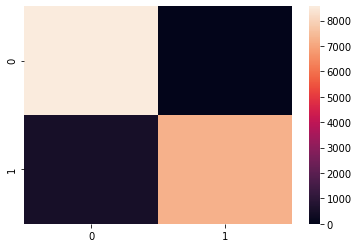

Accuracy Personalize algorithm: 0.9685815776580108


In [31]:
def sigmoid(n1, n2,graph):
  size_n = len(graph.vs())
  n1_degree = graph.vs[n1].degree()
  n2_degree = graph.vs[n2].degree()

  weight = -1

  b = -0

  s = compute_Jaccard(n1,n2,graph)/(n1_degree/size_n*n2_degree/size_n)
  value = 1/(1 + np.exp(weight*(s)))+b
  #print(value)
  return (np.round(value))
import seaborn as sns
from sklearn.metrics import confusion_matrix

def Test_algorithm_sigmoid(testset,graph):
  size = len(testset)
  results = []
  count = 0
  for ind, row in testset.iterrows(): 
    count += 1
    if count%500==0 :  print(count/size)
    result = 1-sigmoid(int(row['n1']), int(row['n2']),graph)
    results.append(result)
  testset['rating']=results
  sns.heatmap(confusion_matrix(testset.edge, testset.rating))
  plt.show()


  # accuracy
  right_predictions = len( testset[testset['rating']==testset['edge']])
  print('Accuracy Personalize algorithm: '+ str(right_predictions/len(testset)))

Test_algorithm_sigmoid(df_test,graph)

